In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
%matplotlib inline

In [11]:
def preprocess(batch):

    freqs = batch[:,0]
    drifts = batch[:,1]
    snrs = batch[:,2]
    skews = batch[:,3]
    kurts = batch[:,4]
    sarles = batch[:,5]
    corrs = batch[:,6]
    tbws = batch[:,7]
    tskews = batch[:,8]
    tstds = batch[:,9]
    fstds = batch[:,10]
    sigbws = batch[:,11]

    normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
    normal_drifts = normal_drifts.reshape(len(normal_drifts))

    data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws)
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6 # units of Hz
                        ])

    return np.transpose(data_arr), np.transpose(data_arr_unscaled)

In [51]:
# Rewrite HDBSCAN pipeline to process data first, then segment into batches.

n_batches = 440

hit_params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
stg_params = np.load('/datax/scratch/benjb/C23_L_full_injected_params.npy', allow_pickle=True)

print(hit_params.shape)
print(stg_params.shape)

full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms

print(full_params.shape)

full_params_scaled, full_params_unscaled = preprocess(full_params)

print(full_params_scaled.shape)

# separate injected hits again so they can be re-injected into each batch later
hit_params_scaled = full_params_scaled[:-10]
hit_params_unscaled = full_params_unscaled[:-10]
stg_params_scaled = full_params_scaled[-10:]
stg_params_unscaled = full_params_unscaled[-10:]

batch_size = len(hit_params) // n_batches

hit_batches_scaled = []
hit_batches_unscaled = []

# shuffle hits before batching
idxs = np.arange(2185987)
np.random.shuffle(idxs) 
hit_params_scaled_shuffled = hit_params_scaled[idxs]
hit_params_unscaled_shuffled = hit_params_unscaled[idxs]
print(hit_params_scaled_shuffled.shape)

for i in range(n_batches):

    if i != n_batches-1:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:(i+1)*batch_size]
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:(i+1)*batch_size]
    else:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:] # catch the last few entries in the final batch
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:]


    #print(batch.shape)
    hit_batches_scaled.append(batch_scaled)
    hit_batches_unscaled.append(batch_unscaled)

(2185987, 12)
(10, 12)
(2185997, 12)
(2185997, 12)
(2185987, 12)


In [52]:
print(hit_batches_scaled[0].shape)

(4968, 12)


In [25]:
def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=40,
        n_jobs=10,
        cluster_selection_method='eom')
    
    X = batch_arr_scaled
    hdb.fit(X)

    labels_list = hdb.labels_

    return labels_list

In [58]:
nmincluster = 3
nminsamples = 2
eps = 0.0

bbb_scaled = np.vstack((hit_batches_scaled[0], stg_params_scaled))
bbb_unscaled = np.vstack((hit_batches_unscaled[0], stg_params_unscaled))
#print(bbb.shape)
#bbb_scaled, bbb_unscaled = preprocess(bbb)

#plt.hist(bbb_scaled[0], bins=50)
#plt.yscale('log')
#plt.show()

print(bbb_scaled.shape)
print(bbb_unscaled.shape)

labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)

print(np.unique(labels_list))
print(labels_list[-10:])
print(len(np.where(labels_list==-1)[0]))
print(len(np.where(labels_list==-1)[0])/len(labels_list))
print(len(np.where(labels_list==len(np.unique(labels_list))-3)[0])/len(labels_list))

(4978, 12)
(4978, 12)
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 

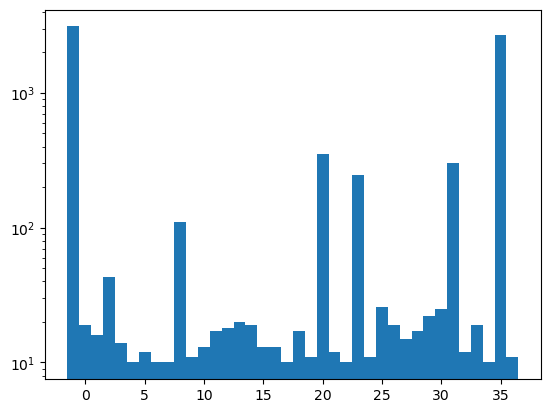

In [37]:
plt.hist(labels_list, bins=len(np.unique(labels_list)), range=[-1.5, np.max(np.unique(labels_list))+0.5])
plt.yscale('log')
plt.show()

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
Scattering ...
Refining ...


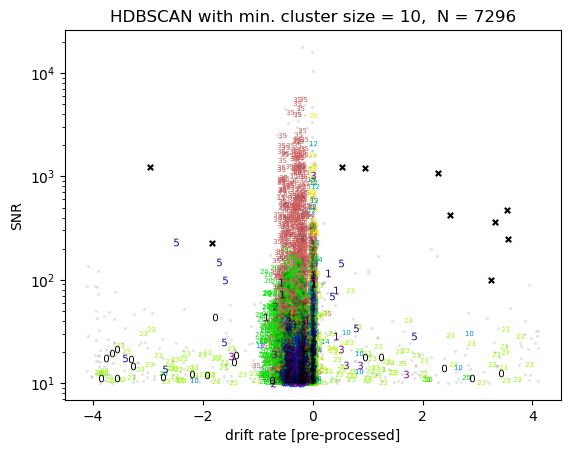

In [36]:
col_idx_x = 1
col_idx_y = 2

df = pd.DataFrame(bbb_scaled,
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

dfu = pd.DataFrame(bbb_unscaled,
                   columns=['frequency [pre-processed]', 
                            'drift rate [pre-processed]', 
                            'SNR', 
                            'spectral skewness', 
                            'spectral kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'time-series standard deviation', 
                            'power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

labels = np.unique(labels_list)
print(labels)

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels[::-1]:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, alpha=0.1, linewidths=0, label=f'n={len(idxs)}')
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([3068, 3069, 3070])
plt.scatter(x[-10:], y[-10:], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()